In [1]:
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import optuna
import mlflow
import pickle
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from torch.utils.data import TensorDataset
import pandas as pd

c:\Users\lhaus\Documents\FH\probabilistic-load-forecast-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DATA_PATH = Path("../../data/processed")

EXPERIMENT_NAME = "fs_002_weather_and_load"
OUTPUT_PATH = DATA_PATH / "ml_data"
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

### Starting the mlflow server for model tracking

To start the server run mlflow server --backend-store-uri sqlite:///mlflow.db --port 5000 in the terminal.

In [3]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("load_forecasting_vanilla_lstm_feature_eval")

<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1767875480688, experiment_id='2', last_update_time=1767875480688, lifecycle_stage='active', name='load_forecasting_vanilla_lstm_feature_eval', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [4]:
# Possible fix for stability in searches
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

print("cudnn.enabled       =", torch.backends.cudnn.enabled)
print("cudnn.benchmark     =", torch.backends.cudnn.benchmark)
print("cudnn.deterministic =", torch.backends.cudnn.deterministic)

cudnn.enabled       = True
cudnn.benchmark     = False
cudnn.deterministic = True


## Vanilla LSTM Model

In [5]:
class VanillaLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, horizon):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )

        self.fc = torch.nn.Linear(hidden_size, horizon)
    
    def forward(self, x):
        out, _ = self.lstm(x) # (batch, seq_len, hidden_size)
        h = out[:, -1, :] # The last hidden state from the last sequential LSTM Cell (batch, hidden_size)

        return self.fc(h) # (batch, horizon)

In [6]:
df = pd.read_parquet(DATA_PATH / "data_combined.parquet")

## Feature Evaluation

In [7]:
def create_sequences(X, y, window_size=4*24*7, forecast_horizon=4*24):
    """
    Create sequences for time series forecasting.
    
    Args:
        X: Feature array (n_samples, n_features)
        y: Target array (n_samples,)
        window_size: Number of time steps to look back
        forecast_horizon: Number of time steps to forecast ahead
        
    Returns:
        X_seq: Array of shape (n_sequences, window_size, n_features)
        y_seq: Array of shape (n_sequences, forecast_horizon)
    """
    n_samples = len(X)
    
    X_seq = []
    y_seq = []
    
    for i in range(n_samples - window_size - forecast_horizon + 1):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size:i+window_size+forecast_horizon])
    
    return (
        np.array(X_seq, dtype=np.float32),
        np.array(y_seq, dtype=np.float32),
    )


In [8]:
FEATURE_SETS = {
    "fs_00_load_only": [
        "actual_load_mw"
    ],

    "fs_01_load_calendar": [
        "actual_load_mw",
        "is_weekday",
        "is_holiday"
    ],

    "fs_02_load_past_weather": [
        "actual_load_mw",
        "t2m", "ssrd",
        "tp", "wind_speed"
    ],

    "fs_03_load_future_weather": [
        "actual_load_mw",
        "t2m_future", "ssrd_future",
        "tp_future", "wind_speed_future"
    ],

    "fs_04_load_past_and_future_weather": [
        "actual_load_mw",
        "t2m", "ssrd",
        "tp", "wind_speed",
        "t2m_future", "ssrd_future",
        "tp_future", "wind_speed_future"
    ],

    "fs_05_load_calendar_past_weather": [
        "actual_load_mw",
        "is_weekday",
        "is_holiday",
        "t2m", "ssrd",
        "tp", "wind_speed"
    ],

    "fs_06_load_calendar_future_weather": [
        "actual_load_mw",
        "is_weekday",
        "is_holiday",
        "t2m_future", "ssrd_future",
        "tp_future", "wind_speed_future"
    ],

    "fs_07_load_calendar_past_and_future_weather": [
        "actual_load_mw",
        "is_weekday",
        "is_holiday",
        "t2m", "ssrd",
        "tp", "wind_speed",
        "t2m_future", "ssrd_future",
        "tp_future", "wind_speed_future"
    ],
}

In [9]:
def run_feature_set(
    df,
    feature_cols,
    window_size,
    horizon,
    tscv,
    model_cls,
    params,
    device
):
    TARGET = "actual_load_mw"

    X_all = df[feature_cols].values
    y_all = df[TARGET].values

    maes = []
    rmses = []

    rmse_h = {
        1: [],
        4: [],
        12: [],
        24: [],
        48: [],
        96: [],
    }

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_all)):
        with mlflow.start_run(run_name=f"fold_{fold}", nested=True):
            X_train_raw, X_test_raw = X_all[train_idx], X_all[test_idx]
            y_train_raw, y_test_raw = y_all[train_idx], y_all[test_idx]

            # --- scaling (fit on train only)
            X_scaler = RobustScaler()
            y_scaler = RobustScaler()

            X_train = X_scaler.fit_transform(X_train_raw)
            y_train = y_scaler.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

            X_test = X_scaler.transform(X_test_raw)
            y_test = y_scaler.transform(y_test_raw.reshape(-1, 1)).ravel()

            # --- windowing
            X_train_seq, y_train_seq = create_sequences(
                X_train, y_train, window_size, horizon
            )
            X_test_seq, y_test_seq = create_sequences(
                X_test, y_test, window_size, horizon
            )

            # --- datasets
            train_ds = TensorDataset(
                torch.from_numpy(X_train_seq),
                torch.from_numpy(y_train_seq),
            )
            test_ds = TensorDataset(
                torch.from_numpy(X_test_seq),
                torch.from_numpy(y_test_seq),
            )

            train_loader = DataLoader(
                train_ds,
                batch_size=params["batch_size"],
                shuffle=True,
            )
            test_loader = DataLoader(
                test_ds,
                batch_size=params["batch_size"],
                shuffle=False,
            )

            # --- model
            model = model_cls(
                input_size=X_train_seq.shape[-1],
                hidden_size=params["hidden_size"],
                num_layers=params["num_layers"],
                dropout=params["dropout"],
                horizon=horizon,
            ).to(device)

            optimizer = torch.optim.Adam(
                model.parameters(),
                lr=params["lr"],
                weight_decay=params["weight_decay"],
            )

            criterion = torch.nn.MSELoss()

            # --- training            
            for epoch in range(30):
                train_loss = 0.0
                model.train()
                for xb, yb in train_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    loss = criterion(model(xb), yb)
                    loss.backward()
                    
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                    optimizer.step()

                    train_loss += loss.item()

                train_loss /= len(train_loader)
                mlflow.log_metric("train_mse", train_loss, step=epoch)

                    

            # --- evaluation (inverse-scaled)
            model.eval()
            preds, trues = [], []
            test_loss = 0.0

            with torch.no_grad():
                for xb, yb in test_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    y_pred_scaled = model(xb) # N, H
                    test_loss += criterion(y_pred_scaled, yb).item()
                    preds.append(y_pred_scaled.cpu().numpy())
                    trues.append(yb.cpu().numpy())

            test_loss /= len(test_loader)
            mlflow.log_metric("test_mse", test_loss)


            preds = y_scaler.inverse_transform(np.vstack(preds))
            trues = y_scaler.inverse_transform(np.vstack(trues))

            mae = mean_absolute_error(preds, trues)
            rmse = root_mean_squared_error(preds, trues)
            
            maes.append(mae)
            rmses.append(rmse)

            mlflow.log_metric("test_mae_unscaled", mae)
            mlflow.log_metric("test_rmse_unscaled", rmse)

            for h in [1, 4, 12, 24, 48, 96]:
                rmse_h_val = root_mean_squared_error(
                    trues[:, h-1],
                    preds[:, h-1]
                )
                rmse_h[h].append(rmse_h_val)

                mlflow.log_metric(f"rmse_h{h}", rmse_h_val)

        del model, optimizer
        torch.cuda.empty_cache()        

    # --- aggregate CV metrics
    mlflow.log_metric("cv_mae_mean", np.mean(maes))
    mlflow.log_metric("cv_mae_std", np.std(maes))

    mlflow.log_metric("cv_rmse_mean", np.mean(rmses))
    mlflow.log_metric("cv_rmse_std", np.std(rmses))

    for h in [1, 4, 12, 24, 48, 96]:
        mlflow.log_metric(
            f"cv_rmse_h{h}_mean",
            np.mean(rmse_h[h])
        )
        mlflow.log_metric(
            f"cv_rmse_h{h}_std",
            np.std(rmse_h[h])
        )
    
    

In [ ]:
params = {
    "hidden_size": 224,
    "num_layers": 2,
    "dropout": 0.15,
    "lr": 3e-4,
    "weight_decay": 1e-5,
    "batch_size": 128,
}


N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

for feature_set_name, features in FEATURE_SETS.items():
    with mlflow.start_run(run_name=f"feature_eval_{feature_set_name}"):

        mlflow.log_params(params)

        run_feature_set(
            df=df,
            feature_cols=features,
            window_size=4*24*7,
            horizon=4*24,
            tscv=tscv,
            model_cls=VanillaLSTM,
            params=params,
            device=DEVICE
        )

🏃 View run fold_0 at: http://127.0.0.1:5000/#/experiments/2/runs/9b828a1d86d44126ba146d2a8d4c4e2e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🏃 View run feature_eval_fs_00_load_only at: http://127.0.0.1:5000/#/experiments/2/runs/55426f19a34040b191a79ce035973d03
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


KeyboardInterrupt: 

In [23]:
window_size = 4*24*7
horizon = 4*24

for fset_name, feature_cols in FEATURE_SETS.items():
    TARGET = "actual_load_mw"
    X_all = df[feature_cols].values

    y_all = df[TARGET].values

    N_SPLITS = 5
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_all)):
        X_train_raw, X_test_raw = X_all[train_idx], X_all[test_idx]
        y_train_raw, y_test_raw = y_all[train_idx], y_all[test_idx]

        # --- scaling (fit on train only)
        X_scaler = RobustScaler()
        y_scaler = RobustScaler()

        X_train = X_scaler.fit_transform(X_train_raw)
        y_train = y_scaler.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

        X_test = X_scaler.transform(X_test_raw)
        y_test = y_scaler.transform(y_test_raw.reshape(-1, 1)).ravel()

        # --- windowing
        X_train_seq, y_train_seq = create_sequences(
            X_train, y_train, window_size, horizon
        )
        X_test_seq, y_test_seq = create_sequences(
            X_test, y_test, window_size, horizon
        )
        assert not np.isnan(X_train).any()
        assert not np.isnan(y_train).any()
        assert not np.isnan(X_test).any()
        assert not np.isnan(y_test).any()
        assert X_test_seq.shape[0] > 0, f"Empty test set in fold {fold}"
        assert not np.isnan(X_train_seq).any()
        assert not np.isnan(y_train_seq).any()
        assert not np.isnan(X_test_seq).any()
        assert not np.isnan(y_test_seq).any()
        assert 1==2

AssertionError: 

## Hyperparameter Search

In [ ]:

def objective(trial):
    with mlflow.start_run(run_name=f"trial_{trial.number}", nested=True):

        trial_dir = OUTPUT_PATH / "artifacts" / f"trial_{trial.number}"
        trial_dir.mkdir(parents=True, exist_ok=True)
        best_model_path = trial / "best_model.pt"

        hidden_size = trial.suggest_int("hidden_size", 64, 256, step=32)
        num_layers  = trial.suggest_int("num_layers", 1, 3)
        dropout = 0.0 if num_layers == 1 else trial.suggest_float("dropout", 0.0, 0.4)
        lr          = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
        batch_size  = trial.suggest_categorical("batch_size", [32, 64, 128])
        weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)


        mlflow.log_params(trial.params)


        model = VanillaLSTM(
            input_size=X_train_seq.shape[-1],
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            horizon=y_train_seq.shape[-1]
        ).to(DEVICE)

        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )

        criterion = torch.nn.MSELoss()

        train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        )

        val_dataloader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False
        )
        
        best_val = float("inf")
        patience = 10
        wait = 0

        for epoch in range(50):
            model.train()
            train_loss = 0.0
            for xb, yb in train_dataloader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                optimizer.zero_grad()
                preds = model(xb)
                torch.cuda.synchronize()

                loss = criterion(preds, yb)
                loss.backward()
                torch.cuda.synchronize()

                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                torch.cuda.synchronize()

                train_loss += loss.item()
                

            train_loss /= len(train_dataloader)
            mlflow.log_metric("train_mse", train_loss, step=epoch)

            model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for xb, yb in val_dataloader:
                    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                    preds = model(xb)
                    val_loss += criterion(preds, yb).item()

            val_loss /= len(val_dataloader)

            mlflow.log_metric("val_mse", val_loss, step=epoch)

            trial.report(val_loss, epoch)

            if trial.should_prune():
                raise optuna.TrialPruned()

            if val_loss < best_val:
                best_val = val_loss
                wait = 0

                torch.save(
                {
                    "model_state_dict": model.state_dict(),
                    "epoch": epoch,
                    "val_mse": val_loss,
                    "trial_number": trial.number,
                    "params": trial.params,
                },
                    best_model_path
                )
                mlflow.log_artifact(str(best_model_path), artifact_path="models")
            else:
                wait += 1

            if wait >= patience:
                break

            torch.cuda.synchronize()


                


        return best_val


In [13]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=1234),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)
with mlflow.start_run(run_name="optuna_search"):
    study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2026-01-08 12:56:56,983] A new study created in memory with name: no-name-eeb59a26-6db4-472c-91ab-93035fd8dd3a


🏃 View run optuna_search at: http://127.0.0.1:5000/#/experiments/1/runs/cb03419041f24fd689e14280a4d7efe1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


NameError: name 'objective' is not defined

In [ ]:
study.best_params

{'hidden_size': 224,
 'num_layers': 3,
 'dropout': 0.023414518146625124,
 'lr': 0.0011000556535137422,
 'batch_size': 128,
 'weight_decay': 3.54214337413836e-05}

After the hyperparameter search is finished the cudnn settings can be reversed for a faster final training.

In [ ]:
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

print("cudnn.enabled       =", torch.backends.cudnn.enabled)
print("cudnn.benchmark     =", torch.backends.cudnn.benchmark)
print("cudnn.deterministic =", torch.backends.cudnn.deterministic)

cudnn.enabled       = True
cudnn.benchmark     = True
cudnn.deterministic = False


In [ ]:
params = {
    "hidden_size": 192,
    "num_layers": 2,
    "dropout": 0.2,
    "lr": 1e-3,
    "weight_decay": 1e-5,
    "batch_size": 64,
}

model_kwargs = {k: params[k] for k in ("hidden_size", "num_layers", "dropout")}
optim_kwargs = {k: params[k] for k in ("lr", "weight_decay")}
batch_size = params["batch_size"]

N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
model = VanillaLSTM(
    input_size=X_train_seq.shape[-1],
    horizon=y_train_seq.shape[-1],
    **model_kwargs
).to(DEVICE)

optimizer = torch.optim.Adam(
    model.parameters(),
    **optim_kwargs
)

criterion = torch.nn.MSELoss()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

best_val = float("inf")
patience = 10
wait = 0

with mlflow.start_run(run_name=f"feature_evaluation_v2_with_weather_data"):
    
    mlflow.log_params(params)

    for epoch in range(50):
        model.train()
        train_loss = 0.0
        for xb, yb in train_dataloader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            preds = model(xb)

            loss = criterion(preds, yb)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        mlflow.log_metric("train_mse", train_loss, step=epoch)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for xb, yb in val_dataloader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                preds = model(xb)
                val_loss += criterion(preds, yb).item()

        val_loss /= len(val_dataloader)
        mlflow.log_metric("val_mse", val_loss, step=epoch)


        if val_loss < best_val:
            best_val = val_loss
            wait = 0
        else:
            wait += 1

        if wait >= patience:
                break
    

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    model.eval()

    all_preds = []
    all_trues = []

    with torch.no_grad():
        for xb, yb in test_dataloader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            y_pred_scaled = model(xb)

            N, H = y_pred_scaled.shape

            y_pred = y_scaler.inverse_transform(
                y_pred_scaled.cpu().numpy().reshape(-1, 1)
            ).reshape(N, H)

            y_true = y_scaler.inverse_transform(
                yb.cpu().numpy().reshape(-1, 1)
            ).reshape(N, H)

            all_preds.append(y_pred)
            all_trues.append(y_true)

    # concat across batches
    y_pred_full = np.concatenate(all_preds, axis=0)
    y_true_full = np.concatenate(all_trues, axis=0)

    mae = mean_absolute_error(y_true_full, y_pred_full)
    rmse = root_mean_squared_error(y_true_full, y_pred_full)

    mlflow.log_metric("test_mae_unscaled", mae)
    mlflow.log_metric("test_rmse_unscaled", rmse)

    for h in [0, 3, 11, 23, 47, 95]:
        mlflow.log_metric(
            f"rmse_h{h+1}",
            root_mean_squared_error(y_true_full[:, h], y_pred_full[:, h])
        )



In [ ]:
best_params = {
    'hidden_size': 224,
    'num_layers': 3,
    'dropout': 0.023414518146625124,
    'lr': 0.0011000556535137422,
    'batch_size': 128,
    'weight_decay': 3.54214337413836e-05
}


model_kwargs = {k: best_params[k] for k in ("hidden_size", "num_layers", "dropout")}
optim_kwargs = {k: best_params[k] for k in ("lr", "weight_decay")}
batch_size = best_params["batch_size"]

model = VanillaLSTM(
    input_size=X_train_seq.shape[-1],
    horizon=y_train_seq.shape[-1],
    **model_kwargs
).to(DEVICE)

optimizer = torch.optim.Adam(
    model.parameters(),
    **optim_kwargs
)

criterion = torch.nn.MSELoss()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

best_val = float("inf")
patience = 10
wait = 0

with mlflow.start_run(run_name=f"final_model_training_weather_load"):
    for epoch in range(50):
        model.train()
        train_loss = 0.0
        for xb, yb in train_dataloader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            preds = model(xb)

            loss = criterion(preds, yb)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        mlflow.log_metric("train_mse", train_loss, step=epoch)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for xb, yb in val_dataloader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                preds = model(xb)
                val_loss += criterion(preds, yb).item()

        val_loss /= len(val_dataloader)
        mlflow.log_metric("val_mse", val_loss, step=epoch)

        mlflow.log_params(model_kwargs)



In [ ]:

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)
model.eval()

all_preds = []
all_trues = []

with torch.no_grad():
    for xb, yb in test_dataloader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        y_pred_scaled = model(xb)

        N, H = y_pred_scaled.shape

        y_pred = y_scaler.inverse_transform(
            y_pred_scaled.cpu().numpy().reshape(-1, 1)
        ).reshape(N, H)

        y_true = y_scaler.inverse_transform(
            yb.cpu().numpy().reshape(-1, 1)
        ).reshape(N, H)

        all_preds.append(y_pred)
        all_trues.append(y_true)

# concat across batches
y_pred_full = np.concatenate(all_preds, axis=0)
y_true_full = np.concatenate(all_trues, axis=0)

mae = mean_absolute_error(y_true_full, y_pred_full)
rmse = root_mean_squared_error(y_true_full, y_pred_full)

mlflow.log_metric("test_mae_unscaled", mae)
mlflow.log_metric("test_rmse_unscaled", rmse)

for h in [0, 3, 11, 23, 47, 95]:
    mlflow.log_metric(
        f"rmse_h{h+1}",
        root_mean_squared_error(y_true_full[:, h], y_pred_full[:, h])
    )



With this final model, the unscaled metrics can be observed.

## Final Model Training

### PyTorch Dataset


In [ ]:
class TimeSeriesDataset(Dataset):
    """PyTorch Dataset for time series forecasting."""
    
    def __init__(self, X, y):
        """
        Args:
            X: Input sequences (n_samples, window_size, n_features)
            y: Target values (n_samples, forecast_horizon)
        """
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train_seq, y_train_seq)
val_dataset = TimeSeriesDataset(X_val_seq, y_val_seq)
test_dataset = TimeSeriesDataset(X_test_seq, y_test_seq)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset:   {len(val_dataset)} samples")
print(f"Test dataset:  {len(test_dataset)} samples")
print(f"Sample shape: X={train_dataset[0][0].shape}, y={train_dataset[0][1].shape}")


Train dataset: 164278 samples
Val dataset:   39879 samples
Test dataset:  39879 samples
Sample shape: X=torch.Size([672, 5]), y=torch.Size([96])


In [ ]:
# Load numpy arrays
scalers_dir = OUTPUT_PATH / "scalers"


X_train_seq = np.load(OUTPUT_PATH / "X_train.npy")
y_train_seq = np.load(OUTPUT_PATH / "y_train.npy")
X_val_seq = np.load(OUTPUT_PATH / "X_val.npy")
y_val_seq = np.load(OUTPUT_PATH / "y_val.npy")
X_test_seq = np.load(OUTPUT_PATH / "X_test.npy")
y_test_seq = np.load(OUTPUT_PATH / "y_test.npy")


with open(scalers_dir / "y_scaler.pkl", "rb") as f:
    y_scaler = pickle.load(f)

In [ ]:
model_dir = OUTPUT_PATH / "models"
model_dir.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), model_dir/ "final_model_v1_state.pt")

In [ ]:
torch.save(model, OUTPUT_PATH / "models/final_model_v1_full.pt")


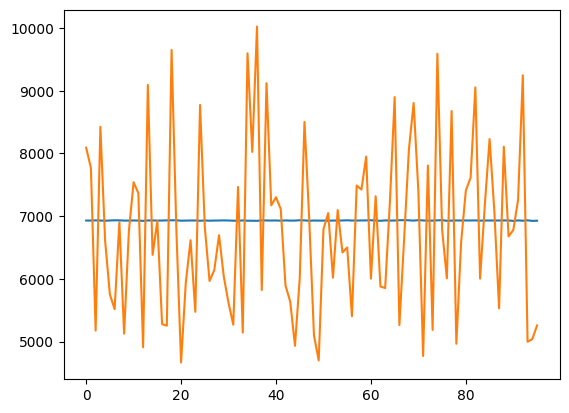

In [ ]:
print(mae)
print(rmse)


plt.plot(y_pred_full[1])
plt.plot(y_true_full[1])